##**Connect Drive**


In [250]:
from google.colab import drive
drive.mount("/gdrive")
current_dir = "/gdrive/MyDrive/pirate_dataset"
%cd $current_dir

ModuleNotFoundError: No module named 'google.colab'

##**Load Dataset**

In [ ]:
import pandas as pd

X_train = pd.read_csv('pirate_pain_train.csv')
y_train = pd.read_csv('pirate_pain_train_labels.csv')

X_test = pd.read_csv('pirate_pain_test.csv')

**Import Libraries**

In [ ]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from datetime import datetime
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.8.0+cu126
Device: cuda


## Data Preprocessing

In [ ]:
# Print the shape of the dataset
print(f"Dataset shape: {X_train.shape}")

# Display the first few rows of the dataset
X_train.head(10)

Dataset shape: (105760, 40)


,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,3.999558e-06,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,6.019627e-06,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,1.446051e-06,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,1.847597e-06,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,1.552722e-06,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5
5,0,5,2,0,2,1,two,two,two,1.146031,...,1.073167e-06,1.753837e-07,2.957340e-07,6.217311e-08,0.000007,0.006150,0.006444,0.033101,0.023767,0.5
6,0,6,2,1,2,1,two,two,two,1.025870,...,1.074800e-06,1.772156e-07,1.976558e-06,1.576086e-06,0.000005,0.006495,0.006421,0.031804,0.019056,0.5
7,0,7,2,2,2,2,two,two,two,1.038597,...,8.829074e-07,1.790415e-07,2.210562e-06,1.485741e-06,0.000000,0.015998,0.005397,0.035552,0.015732,0.5
8,0,8,2,2,0,1,two,two,two,0.984251,...,1.621055e-06,1.165161e-06,3.030164e-07,5.416678e-07,0.000000,0.020539,0.008517,0.008635,0.015257,0.5
9,0,9,0,2,2,2,two,two,two,1.054999,...,1.609114e-06,3.959558e-06,2.017157e-06,1.154349e-06,0.000007,0.007682,0.021383,0.034006,0.028966,0.5


In [ ]:
# Display a summary of the dataset's structure and data types
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

In [ ]:
# Merge features and labels
data = X_train.merge(y_train, on='sample_index')

# Create a mapping dictionary to convert categorical labels to numerical values
map_dict = {'none': 0, 'one': 1, 'two': 2}
data['n_legs'] = data['n_legs'].map(map_dict)
data['n_hands'] = data['n_hands'].map(map_dict)
data['n_eyes'] = data['n_eyes'].map(map_dict)


In [ ]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split

# df has columns: ['sample_index', 'label']
N_VAL_USERS = 80
N_TEST_USERS = 3

# --- Step 1: Compute each user's dominant label (or label distribution)
user_labels = (
    data.groupby('sample_index')['label']
    .agg(lambda x: x.value_counts().index[0])  # dominant label per user
    .reset_index()
)

train_users, temp_users = train_test_split(
    user_labels['sample_index'],
    test_size=(N_VAL_USERS + N_TEST_USERS) / len(user_labels),
    stratify=user_labels['label'],
    random_state=SEED
)

# Split temp into val/test (also stratified)
temp_labels = user_labels[user_labels['sample_index'].isin(temp_users)]

val_users, test_users = train_test_split(
    temp_labels['sample_index'],
    test_size=N_TEST_USERS / (N_VAL_USERS + N_TEST_USERS),
    stratify=temp_labels['label'],
    random_state=SEED
)

# --- Step 3: Filter your main df
df_train = data[data['sample_index'].isin(train_users)]
df_val = data[data['sample_index'].isin(val_users)]
df_test = data[data['sample_index'].isin(test_users)]

# --- Step 4: Check label proportions
print("Label proportions:")
print("Train:\n", df_train['label'].value_counts(normalize=True))
print("Val:\n", df_val['label'].value_counts(normalize=True))
print("Test:\n", df_test['label'].value_counts(normalize=True))

Label proportions:
Train:
 label
no_pain      0.773356
low_pain     0.141869
high_pain    0.084775
Name: proportion, dtype: float64
Val:
 label
no_pain      0.7750
low_pain     0.1375
high_pain    0.0875
Name: proportion, dtype: float64
Test:
 label
no_pain     0.666667
low_pain    0.333333
Name: proportion, dtype: float64


In [ ]:
df_train.shape, df_val.shape, df_test.shape

((92480, 41), (12800, 41), (480, 41))

In [ ]:
# Print the total number of pirates for each dataset
print(f"Total pirates in training set: {df_train['sample_index'].nunique()}")
print(f"Total pirates in validation set: {df_val['sample_index'].nunique()}")
print(f"Total pirates in test set: {df_test['sample_index'].nunique()}")

Total pirates in training set: 578
Total pirates in validation set: 80
Total pirates in test set: 3


In [ ]:
data.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,2,0,2,1,2.0,2.0,2.0,1.094705,...,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain
1,0,1,2,2,2,2,2.0,2.0,2.0,1.135183,...,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain
2,0,2,2,0,2,2,2.0,2.0,2.0,1.080745,...,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain
3,0,3,2,2,2,2,2.0,2.0,2.0,0.938017,...,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain
4,0,4,2,2,2,2,2.0,2.0,2.0,1.090185,...,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 41 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         104800 non-null  float64
 7   n_hands        104800 non-null  float64
 8   n_eyes         104800 non-null  float64
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

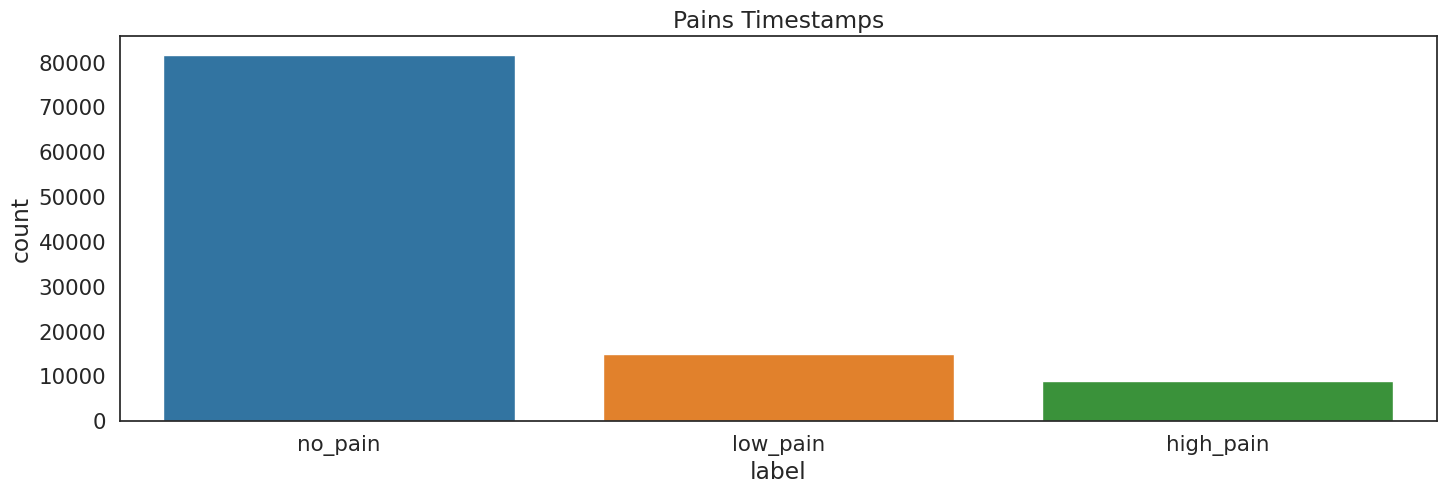

In [ ]:
import seaborn as sns

# Visualise the count of timestamps for each pains
plt.figure(figsize=(17, 5))
sns.countplot(
    x='label',
    data=data,
    order=data['label'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Pains Timestamps')

# Display the plot
plt.show()

In [ ]:
# Define the columns to be normalised
scale_columns = [col for col in data.columns
                 if (col.startswith('joint_') or col.startswith('pain_survey')) and not col.startswith('joint_30')]

# Calculate the minimum and maximum values from the training data only
mins_train = df_train[scale_columns].min()
maxs_train = df_train[scale_columns].max()

mins_val = df_val[scale_columns].min()
maxs_val = df_val[scale_columns].max()

mins_test = df_test[scale_columns].min()
maxs_test = df_test[scale_columns].max()


# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    # Normalise the training set
    df_train[column] = (df_train[column] - mins_train[column]) / (maxs_train[column] - mins_train[column])

    # Normalise the validation set
    df_val[column] = (df_val[column] - mins_val[column]) / (maxs_val[column] - mins_val[column])

    # Normalise the test set
    df_test[column] = (df_test[column] - mins_test[column]) / (maxs_test[column] - mins_test[column])


In [ ]:
data.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30,label
0,0,0,2,0,2,1,2.0,2.0,2.0,1.094705,...,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5,no_pain
1,0,1,2,2,2,2,2.0,2.0,2.0,1.135183,...,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5,no_pain
2,0,2,2,0,2,2,2.0,2.0,2.0,1.080745,...,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5,no_pain
3,0,3,2,2,2,2,2.0,2.0,2.0,0.938017,...,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5,no_pain
4,0,4,2,2,2,2,2.0,2.0,2.0,1.090185,...,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5,no_pain


In [ ]:
# Define a function to inspect sensor data for a specific label
def inspect_label(label, df):
    # Filter the DataFrame for the specified label and limit to 159 rows
    data = df[df['label'] == label][['joint_00', 'joint_01', 'joint_11', 'joint_15', 'joint_23', 'joint_28']][:159]

    # Plot the sensor data for each axis
    axis = data.plot(subplots=True, figsize=(17, 9), title=label)

    # Adjust legend position for each subplot
    for ax in axis:
        ax.legend(loc='lower right')

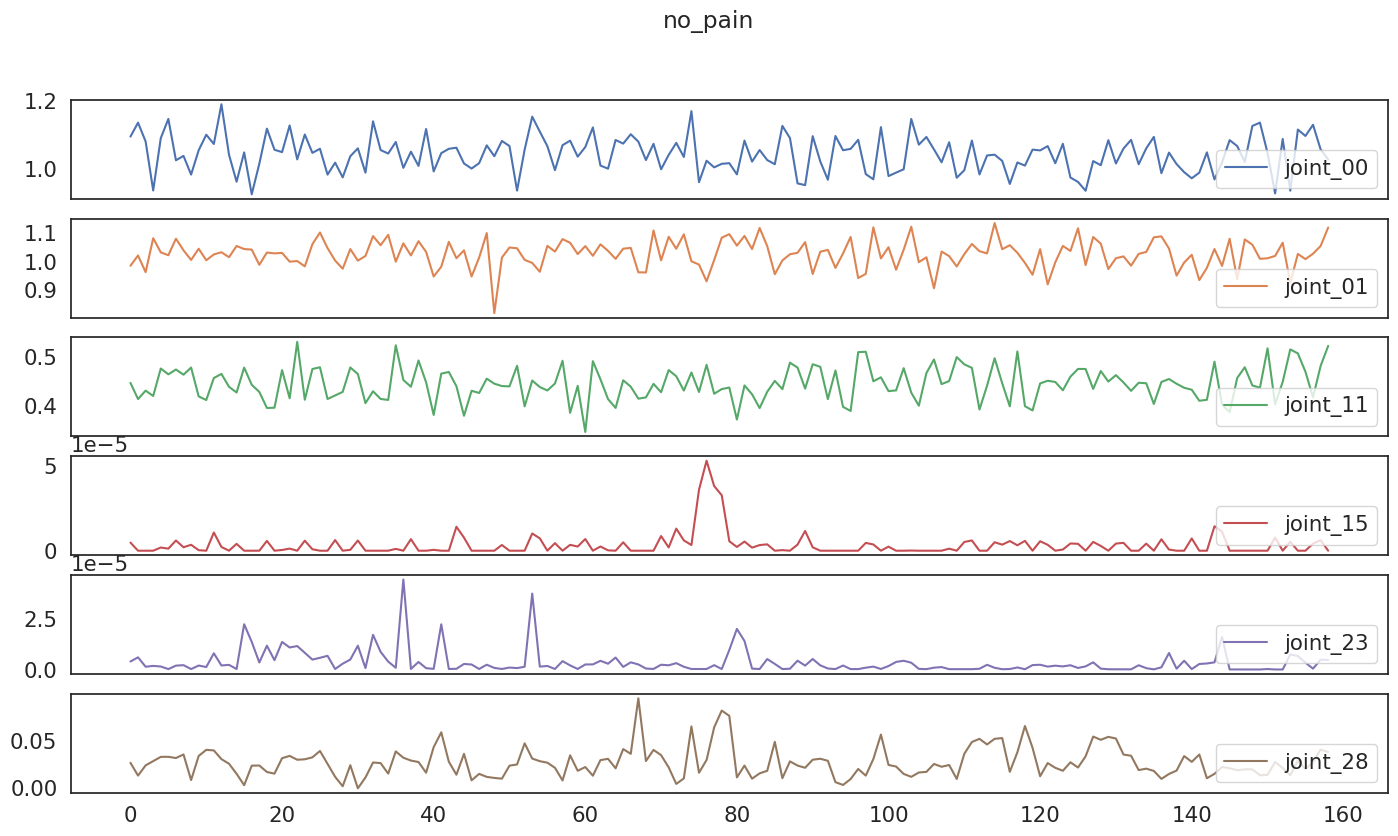

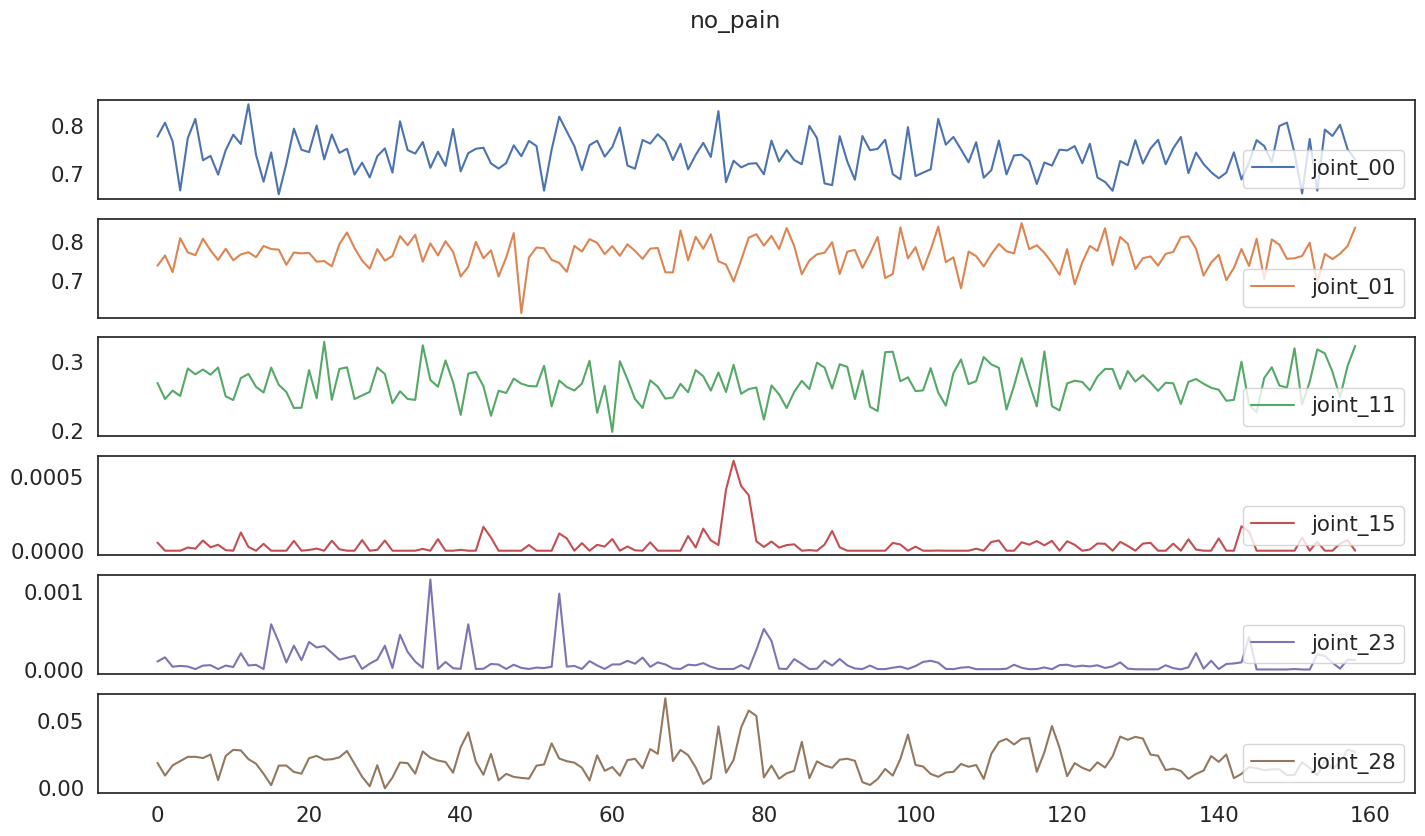

In [ ]:
inspect_label('no_pain', data)

# Normalized training data
inspect_label('no_pain', df_train)

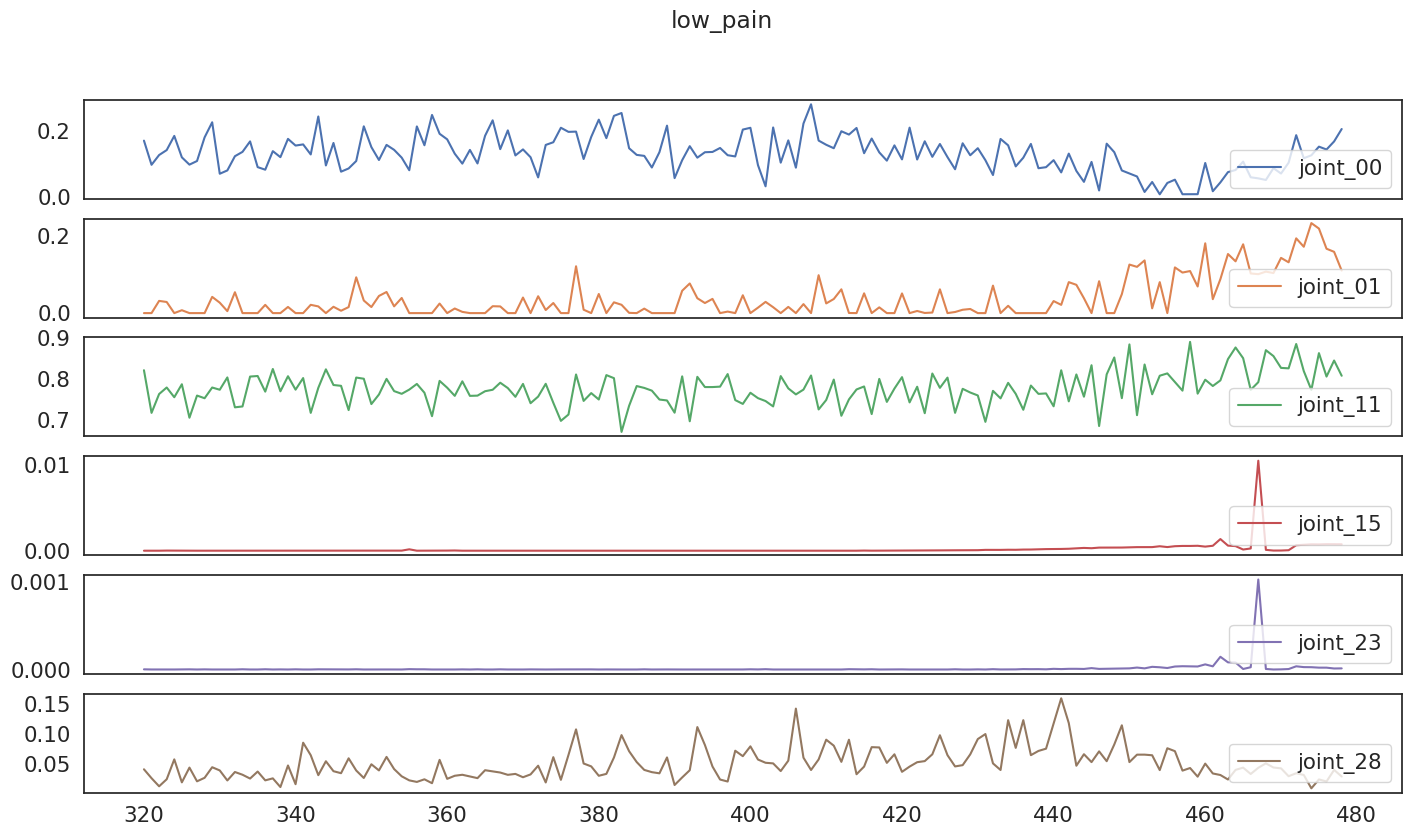

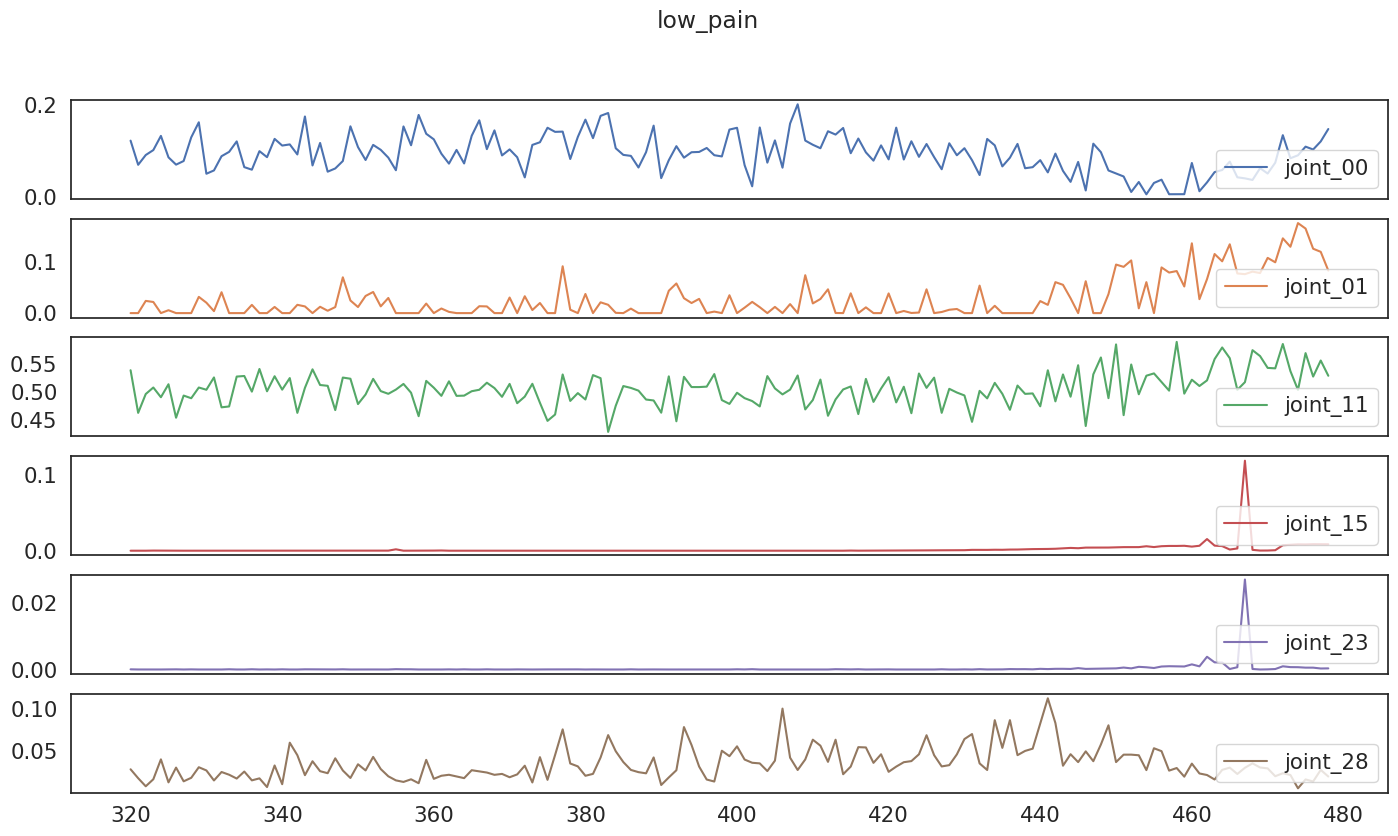

In [ ]:
inspect_label('low_pain', data)

# Normalized training data
inspect_label('low_pain', df_train)

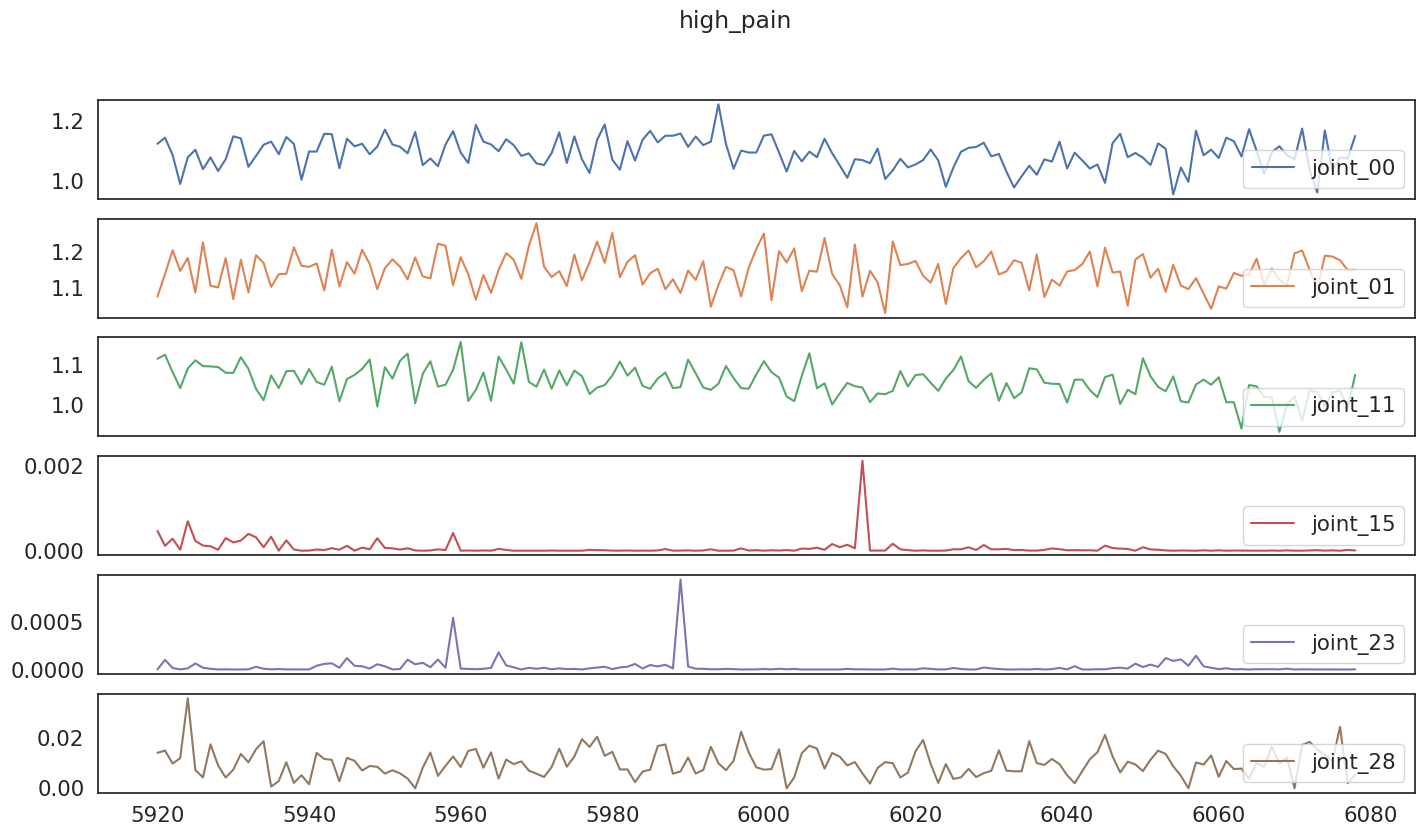

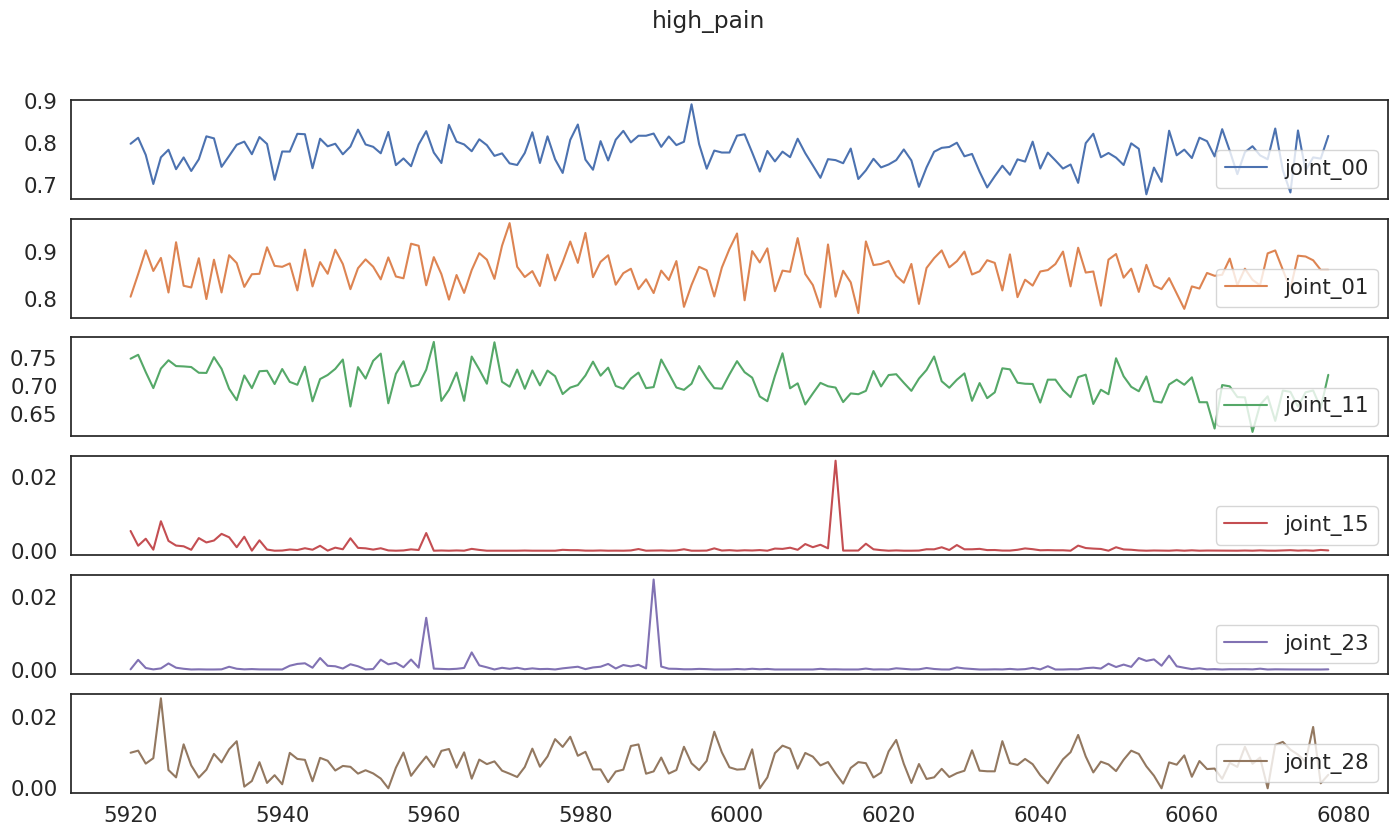

In [ ]:
inspect_label('high_pain', data)

# Normalized training data
inspect_label('high_pain', df_train)

In [ ]:
# Initialise a dictionary to count occurrences of each activity in the training set
training_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each activity for unique IDs in the training set
for id in df_train['sample_index'].unique():
    label = df_train[df_train['sample_index'] == id]['label'].values[0]
    training_labels[label] += 1


if 'joint_30' in df_train.columns:
    df_train = df_train.drop(columns=['joint_30']) # we deleted this joint since has no final effect during training

# Print the distribution of training labels
print('Training labels:', training_labels)

# Initialise a dictionary to count occurrences of each activity in the training set
val_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each activity for unique IDs in the training set
for id in df_val['sample_index'].unique():
    label = df_val[df_val['sample_index'] == id]['label'].values[0]
    val_labels[label] += 1


if 'joint_30' in df_val.columns:
    df_val = df_val.drop(columns=['joint_30']) # we deleted this joint since has no final effect during training

# Print the distribution of validation labels
print('Validation labels:', val_labels)

# Initialise a dictionary to count occurrences of each activity in the test set
test_labels = {
    'no_pain': 0,
    'low_pain': 0,
    'high_pain': 0
}

# Count occurrences of each activity for unique IDs in the test set
for id in df_test['sample_index'].unique():
    label = df_test[df_test['sample_index'] == id]['label'].values[0]
    test_labels[label] += 1
if 'joint_30' in df_test.columns:
    df_test = df_test.drop(columns=['joint_30']) # we deleted this joint since has no final effect during training

# Print the distribution of test labels
print('Test labels:', test_labels)

Training labels: {'no_pain': 447, 'low_pain': 82, 'high_pain': 49}
Validation labels: {'no_pain': 62, 'low_pain': 11, 'high_pain': 7}
Test labels: {'no_pain': 2, 'low_pain': 1, 'high_pain': 0}


In [ ]:
df_train.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,label
0,0,0,1.0,0.0,1.0,0.5,2.0,2.0,2.0,0.777507,...,2.426544e-06,1.503263e-06,0.000105,0.000405,0.000004,0.014214,0.011376,0.018978,0.020291,no_pain
1,0,1,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.806256,...,2.757563e-07,4.403064e-07,0.000158,0.000001,0.000000,0.010748,0.000000,0.009473,0.010006,no_pain
2,0,2,1.0,0.0,1.0,1.0,2.0,2.0,2.0,0.767592,...,1.063529e-07,1.575589e-08,0.000038,0.000085,0.000003,0.013097,0.006830,0.017065,0.016856,no_pain
3,0,3,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.666220,...,6.981461e-06,3.352260e-07,0.000049,0.000002,0.000000,0.009505,0.006274,0.020264,0.017981,no_pain
4,0,4,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.774297,...,3.076737e-06,1.885071e-08,0.000041,0.000002,0.000007,0.004216,0.002132,0.023389,0.018477,no_pain


In [ ]:
# Define a training mapping of label names to integer labels
train_label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Map label names to integers in the training set
df_train['label'] = df_train['label'].map(train_label_mapping)

# Define a validation mapping of label names to integer labels
val_label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Map label names to integers in the validation set
df_val['label'] = df_val['label'].map(val_label_mapping)

test_label_mapping = {
    'no_pain': 0,
    'low_pain': 1,
    'high_pain': 2
}

# Map label names to integers in the test set
df_test['label'] = df_test['label'].map(test_label_mapping)


In [ ]:
df_train['label'].head()

,label
0,0
1,0
2,0
3,0
4,0


In [ ]:
df_val['label'].head()

,label
2080,1
2081,1
2082,1
2083,1
2084,1


In [ ]:
df_test['label'].head()

,label
5280,0
5281,0
5282,0
5283,0
5284,0


In [ ]:

# Define window and stride boolean variable -> if True, during training we will visit more time the same pirate with overlapping windows
# if False, each pirate will be visited only once during training
one_pirate_window = True

In [ ]:
if one_pirate_window:
    # Define the window size
    WINDOW_SIZE = 40 # before: 80

    # Stride size
    STRIDE = 20
else:
    # Define the window size -> select an higher window size in order to get more pirates
    WINDOW_SIZE = 320

    # Stride size
    STRIDE = 80

In [ ]:
"""
  GENERAL COMMENTS:
  in this function we are restricting for each user data the number of samples of recorded data to a constant
  value (window size), since every user data could be composed by different numbers of timestep. Therefore we are
  "normalizing" the timesteps of a constant window size. Additionally is also defined a stride variable, which if is equal to
  the window size, then we are not taking overlapping timestamp samples, instead if stride < window, we are letting some samples
  to overlap in such a way that the RNN or other kind of NN architecture will analyze better the context.
"""

# Define a function to build sequences from the dataset
def build_sequences(df, window=200, stride=200):
    # Sanity check to ensure the window is divisible by the stride
    assert window % stride == 0 # checks if the window size is divisible by the stride

    # Initialise lists to store sequences and their corresponding labels
    dataset = []
    labels = []

    # Iterate over unique IDs in the DataFrame
    for id in df['sample_index'].unique():

        # Extract pirate sample index data for the current sample index
        columns = [col for col in df.columns if col not in ['sample_index', 'label', 'time']]

        temp = df[df['sample_index'] == id][columns].values

        # Retrieve the label for the current pirate
        label = df[df['sample_index'] == id]['label'].values[0]

        # Calculate padding length to ensure full windows
        padding_len = window - len(temp) % window

        # Create zero padding and concatenate with the data
        padding = np.zeros((padding_len, len(columns)), dtype='float32')
        temp = np.concatenate((temp, padding))

        # Build feature windows and associate them with labels
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride

    # Convert lists to numpy arrays for further processing
    dataset = np.array(dataset)
    labels = np.array(labels)

    return dataset, labels

In [ ]:
# Generate sequences and labels for the training set
X_train, y_train = build_sequences(df_train, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the validation set
X_val, y_val = build_sequences(df_val, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the test set
X_test, y_test = build_sequences(df_test, WINDOW_SIZE, STRIDE)

# Print the shapes of the generated datasets and their labels
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((5202, 40, 37), (5202,), (720, 40, 37), (720,), (27, 40, 37), (27,))

In [ ]:
# Convert dataset into float32 for PyTorch compatibility
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
# y_train = y_train.astype('int64')
# y_val = y_val.astype('int64')
# y_test = y_test.astype('int64')

In [ ]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [ ]:

# Discard nan values from the dataset
if np.isnan(X_train).any() or np.isnan(X_val).any() or np.isnan(X_test).any():
    X_train = np.nan_to_num(X_train)
    X_val = np.nan_to_num(X_val)
    X_test = np.nan_to_num(X_test)


In [ ]:
# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

In [ ]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 256 # we can change it depending on the GPU RAM available (by default 512)

In [ ]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [ ]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [ ]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([256, 40, 37])
Labels batch shape: torch.Size([256])


In [ ]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [ ]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0 # dropout between RNN layers, applied for regularization

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional, # We are defining a bidirectional RNN since we want to extract also the future contextual information for making better predictions
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes) # output layer for classifying

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x) # feeds the input sequence into the RNN layer
        # rnn_out -> contains the hidden state output for every timestep

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]  # final hidden state of the last timestep

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits


# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=128, # Prev. hidden size: 128
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.2,
    rnn_type='RNN'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 40, 128], [2, -1, 128]] 54,400         
classifier (Linear)       [-1, 3]                      387            
Total params: 54,787
Trainable params: 54,787
Non-trainable params: 0
-------------------------------------------------------------------------------


## Network Hyperparameters

In [ ]:
# Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 100

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 80        # Neurons per layer -> prev hidden size = 128

# Regularisation
DROPOUT_RATE = 0.2         # Dropout probability

# For now disable weight decay
L1_LAMBDA = 0.6            # L1 penalty
L2_LAMBDA = 0.2            # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

In [ ]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

## Training

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [ ]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [ ]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [ ]:
%%time

# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=True,
    rnn_type='LSTM'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "lstm_higher_patiance"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="lstm_bi",
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 40, 160], [4, -1, 80]] 231,040        
classifier (Linear)       [-1, 3]                      483            
Total params: 231,523
Trainable params: 231,523
Non-trainable params: 0
-------------------------------------------------------------------------------
Training 500 epochs...
Epoch   1/500 | Train: Loss=0.8156, F1 Score=0.6555 | Val: Loss=0.7245, F1 Score=0.6768
Epoch   2/500 | Train: Loss=0.7089, F1 Score=0.6745 | Val: Loss=0.6829, F1 Score=0.6768
Epoch   3/500 | Train: Loss=0.6831, F1 Score=0.6745 | Val: Loss=0.6741, F1 Score=0.6768
Epoch   4/500 | Train: Loss=0.6583, F1 Score=0.6777 | Val: Loss=0.6126, F1 Score=0.7055
Epoch   5/500 | Train: Loss=0.6164, F1 Score=0.7116 | Val: Loss=0.6170, F1 Score=0.7359
Epoch   6/500 | Train: Loss=0.6319, F1 Score=0.7227 | Val: Loss=0.6101, F1 Score=0.7223
E

In [ ]:
# %%time

# Create model and display architecture with parameter count
# rnn_model = RecurrentClassifier(
#     input_size=input_shape[-1], # Pass the number of features
#     hidden_size=HIDDEN_SIZE,
#     num_layers=HIDDEN_LAYERS,
#     num_classes=num_classes,
#     dropout_rate=DROPOUT_RATE,
#     bidirectional=False,
#     rnn_type='LSTM'
#     ).to(device)
# recurrent_summary(rnn_model, input_size=input_shape)

# # Set up TensorBoard logging and save model architecture
# experiment_name = "lstm_less_patiance"
# writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
# x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
# writer.add_graph(rnn_model, x)

# # Define optimizer with L2 regularization
# optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# # Enable mixed precision training for GPU acceleration
# scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

# # Smaller PATIENCE
# PATIENCE = 50

# # Train model and track training history
# rnn_model, training_history = fit(
#     model=rnn_model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     epochs=EPOCHS,
#     criterion=criterion,
#     optimizer=optimizer,
#     scaler=scaler,
#     device=device,
#     writer=writer,
#     verbose=1,
#     experiment_name="rnn",
#     patience=PATIENCE
#     )

# # Update best model if current performance is superior
# if training_history['val_f1'][-1] > best_performance:
#     best_model = rnn_model
#     best_performance = training_history['val_f1'][-1]

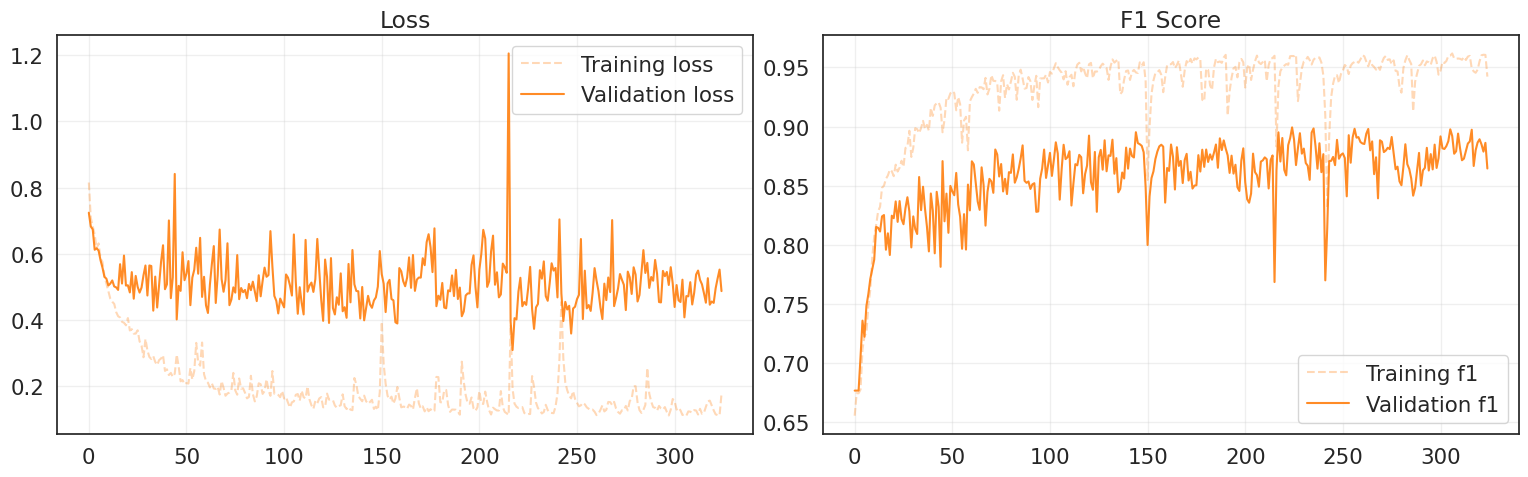

In [ ]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.8972
Precision over the validation set: 0.8929
Recall over the validation set: 0.8972
F1 score over the validation set: 0.8935


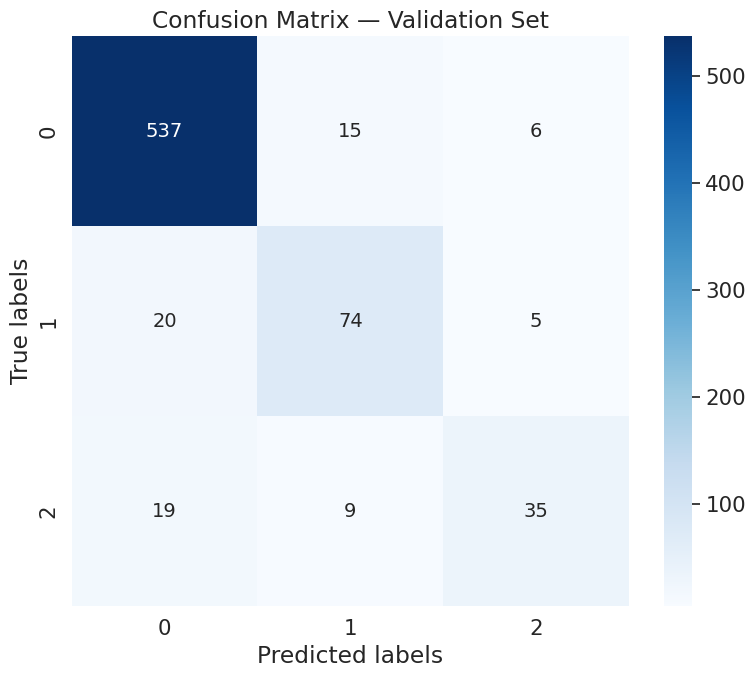

In [ ]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

In [ ]:
# Copy TensorBoard logs to accessible location for Colab
# !rsync -a $current_dir"/"$logs_dir/ "/content/"$logs_dir/

# # Launch TensorBoard interface
# %tensorboard --logdir "/content/"$logs_dir

In [258]:
# --- Load and preprocess the actual test dataset ---
print("Loading test dataset for final evaluation...")

# Load the actual test dataset (this doesn't have labels)
X_test_final = pd.read_csv('dataset/pirate_pain_test.csv')

# Create a mapping dictionary to convert categorical labels to numerical values
map_dict = {'none': 0, 'one': 1, 'two': 2}
X_test_final['n_legs'] = X_test_final['n_legs'].map(map_dict)
X_test_final['n_hands'] = X_test_final['n_hands'].map(map_dict)
X_test_final['n_eyes'] = X_test_final['n_eyes'].map(map_dict)

# Convert inputs from float64 to float32
X_test_final = X_test_final.astype(np.float32)

# # Remove joint_30 if it exists (to match training data)
# if 'joint_30' in X_test_final.columns:
#     X_test_final = X_test_final.drop(columns=['joint_30'])
#     print("Removed 'joint_30' column to match training data")

# Define the columns to be normalised (use training statistics for proper normalization)
scale_columns = [col for col in X_test_final.columns
                 if (col.startswith('joint_') or col.startswith('pain_survey')) and not col.startswith('joint_30')]

# Use training data statistics for normalization
print("Normalizing test data using training statistics...")
for column in scale_columns:
    if column in df_train.columns:
        # Use training min/max for proper normalization
        train_min = df_train[column].min()
        train_max = df_train[column].max()
        X_test_final[column] = (X_test_final[column] - train_min) / (train_max - train_min)
    else:
        print(f"Warning: Column {column} not found in training data")

# For testing on our internal test set (with labels), use the processed data
print(f"Internal test set shape: {X_test.shape}")
print(f"Actual test dataset shape: {X_test_final.shape}")

# Create model with the correct input size (based on actual number of features)
print(f"Expected input features: {input_shape[-1]}")
print(f"Actual input features in test data: {X_test.shape[-1]}")

# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=37,  # Use the correct input size from training
    hidden_size=80,  # Match the saved model architecture
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=True,
    rnn_type='LSTM'
    ).to(device)

print(f"Model created with input_size={input_shape[-1]}, hidden_size=80")
recurrent_summary(rnn_model, input_size=input_shape)


# Load the trained model
model_path = "models/lstm_bi_model.pt"

try:
    # Load the state dict
    checkpoint = torch.load(model_path, map_location=device)
    rnn_model.load_state_dict(checkpoint)
    print(f"✓ Model successfully loaded from {model_path}")
    
    # Verify model architecture matches
    total_params = sum(p.numel() for p in rnn_model.parameters())
    print(f"✓ Model loaded with {total_params:,} parameters")
    
except FileNotFoundError:
    print(f"✗ ERROR: Model file not found at {model_path}")
    print("Please ensure the model was trained and saved properly.")
    print("You may need to retrain the model or check the file path.")
    
except RuntimeError as e:
    print(f"✗ ERROR: Model architecture mismatch!")
    print(f"Error details: {str(e)}")
    print("\nThis usually happens when:")
    print("1. The saved model has different architecture than current model")
    print("2. Different input_size, hidden_size, or num_layers")
    print("3. Different bidirectional setting")
    print("\nTrying to create model with saved architecture...")
    
    # Try different architecture combinations that might match the saved model
    possible_configs = [
        {'hidden_size': 128, 'input_size': 37},  # Original training config
        {'hidden_size': 80, 'input_size': 37},   # Current config
        {'hidden_size': 128, 'input_size': 38},  # In case joint_30 was included
    ]
    
    model_loaded = False
    for config in possible_configs:
        try:
            print(f"Trying: hidden_size={config['hidden_size']}, input_size={config['input_size']}")
            test_model = RecurrentClassifier(
                input_size=config['input_size'],
                hidden_size=config['hidden_size'],
                num_layers=HIDDEN_LAYERS,
                num_classes=num_classes,
                dropout_rate=DROPOUT_RATE,
                bidirectional=True,
                rnn_type='LSTM'
            ).to(device)
            
            test_model.load_state_dict(checkpoint)
            rnn_model = test_model
            print(f"✓ Successfully loaded with hidden_size={config['hidden_size']}, input_size={config['input_size']}")
            model_loaded = True
            break
            
        except RuntimeError:
            continue
    
    if not model_loaded:
        print("✗ Could not load the model with any configuration.")
        print("Please retrain the model or check the saved file.")
        raise e

rnn_model.eval()  # Set model to evaluation mode

print("Starting model evaluation on test set...")

# Verify data dimensions before inference
print(f"Model input size: {rnn_model.rnn.input_size}")
print(f"Test data feature size: {X_test.shape[-1]}")

if rnn_model.rnn.input_size != X_test.shape[-1]:
    print("WARNING: Input size mismatch detected!")
    print(f"Model expects {rnn_model.rnn.input_size} features, but data has {X_test.shape[-1]}")
    
    if X_test.shape[-1] > rnn_model.rnn.input_size:
        print("Trimming extra features from test data...")
        X_test = X_test[:, :, :rnn_model.rnn.input_size]
        print(f"New test data shape: {X_test.shape}")
        
        # Recreate the test dataset and loader with corrected data
        test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
        test_loader = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
    else:
        print("Test data has fewer features than expected. Please check data preprocessing.")
        raise ValueError(f"Cannot proceed with {X_test.shape[-1]} features when model expects {rnn_model.rnn.input_size}")

# --- Comprehensive Testing Pipeline ---
test_preds, test_targets = [], []
test_probabilities = []

print(f"Running inference on {len(test_loader)} batches...")

with torch.no_grad():  # Disable gradient computation for inference
    for batch_idx, (xb, yb) in enumerate(test_loader):
        xb = xb.to(device)
        
        # Verify batch dimensions
        if batch_idx == 0:
            print(f"Batch input shape: {xb.shape}")
            print(f"Expected: (batch_size, {input_shape[0]}, {rnn_model.rnn.input_size})")
        
        # Get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        
        # Get probabilities for confidence analysis
        probabilities = torch.softmax(logits, dim=1).cpu().numpy()
        
        # Store batch results
        test_preds.append(preds)
        test_targets.append(yb.numpy())
        test_probabilities.append(probabilities)
        
        # Progress indicator
        if (batch_idx + 1) % 5 == 0 or (batch_idx + 1) == len(test_loader):
            print(f"Processed batch {batch_idx + 1}/{len(test_loader)}")

# Combine all batches into single arrays
test_preds = np.concatenate(test_preds)
test_targets = np.concatenate(test_targets)
test_probabilities = np.concatenate(test_probabilities)

print(f"\nTest set evaluation completed successfully!")
print(f"Total test samples: {len(test_preds)}")
print(f"Predictions shape: {test_preds.shape}")
print(f"Targets shape: {test_targets.shape}")
print(f"Probabilities shape: {test_probabilities.shape}")

Loading test dataset for final evaluation...
Normalizing test data using training statistics...
Internal test set shape: (50, 320, 38)
Actual test dataset shape: (211840, 40)
Expected input features: 38
Actual input features in test data: 38
Model created with input_size=38, hidden_size=80
Error during dummy forward pass: input.size(-1) must be equal to input_size. Expected 37, got 38
✓ Model successfully loaded from models/lstm_bi_model.pt
✓ Model loaded with 231,523 parameters
Starting model evaluation on test set...
Model input size: 37
Test data feature size: 38
Model expects 37 features, but data has 38
Trimming extra features from test data...
New test data shape: (50, 320, 37)
Running inference on 1 batches...
Batch input shape: torch.Size([50, 320, 37])
Expected: (batch_size, 320, 37)
Processed batch 1/1

Test set evaluation completed successfully!
Total test samples: 50
Predictions shape: (50,)
Targets shape: (50,)
Probabilities shape: (50, 3)


In [259]:
# --- Rebuild test sequences with correct preprocessing ---
print("Rebuilding test sequences to ensure compatibility...")

# First, let's check what features were actually used in training
print(f"Training data columns (excluding metadata): {df_train.shape[1] - 2}")  # -2 for sample_index and label
print(f"Expected model input size: {input_shape[-1]}")

# Recreate the test sequences using the training preprocessing pipeline
X_test_corrected, y_test_corrected = build_sequences(
    df_test,
    window=WINDOW_SIZE,
    stride=STRIDE
)

X_test_corrected = X_test_corrected.astype(np.float32)
y_test_corrected = y_test_corrected.astype(np.int32)

print(f"Corrected test data shape: {X_test_corrected.shape}")
print(f"Expected: (num_samples, {WINDOW_SIZE}, {input_shape[-1]})")

# Check if dimensions match
if X_test_corrected.shape[-1] != input_shape[-1]:
    print(f" Feature dimension mismatch!")
    print(f"Test data: {X_test_corrected.shape[-1]} features")
    print(f"Expected: {input_shape[-1]} features")
    
    # Adjust the data to match expected dimensions
    if X_test_corrected.shape[-1] > input_shape[-1]:
        print("Trimming excess features...")
        X_test_corrected = X_test_corrected[:, :, :input_shape[-1]]
    else:
        print(" Test data has fewer features than training data!")
        print("This suggests a preprocessing inconsistency.")
        
        # Show which columns are missing
        train_cols = [col for col in df_train.columns if col not in ['sample_index', 'label', 'time']]
        test_cols = [col for col in df_test.columns if col not in ['sample_index', 'label', 'time']]
        
        missing_in_test = set(train_cols) - set(test_cols)
        extra_in_test = set(test_cols) - set(train_cols)
        
        if missing_in_test:
            print(f"Missing in test: {missing_in_test}")
        if extra_in_test:
            print(f"Extra in test: {extra_in_test}")

# Use the corrected data
X_test = X_test_corrected
y_test = y_test_corrected

# Recreate the test DataLoader
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = make_loader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=False
)

print(f"Test DataLoader created with shape: {X_test.shape}")
print(f"Features per timestep: {X_test.shape[-1]}")
print(f"Sequence length: {X_test.shape[1]}")
print(f"Total test samples: {X_test.shape[0]}")

Rebuilding test sequences to ensure compatibility...
Training data columns (excluding metadata): 39
Expected model input size: 38
Corrected test data shape: (50, 320, 38)
Expected: (num_samples, 320, 38)
Test DataLoader created with shape: (50, 320, 38)
Features per timestep: 38
Sequence length: 320
Total test samples: 50


In [260]:
# --- Comprehensive Test Set Evaluation ---

# Calculate all evaluation metrics
test_accuracy = accuracy_score(test_targets, test_preds)
test_precision = precision_score(test_targets, test_preds, average='weighted')
test_recall = recall_score(test_targets, test_preds, average='weighted')
test_f1 = f1_score(test_targets, test_preds, average='weighted')

# Per-class metrics
test_precision_per_class = precision_score(test_targets, test_preds, average=None)
test_recall_per_class = recall_score(test_targets, test_preds, average=None)
test_f1_per_class = f1_score(test_targets, test_preds, average=None)

print("=" * 60)
print("               TEST SET EVALUATION RESULTS")
print("=" * 60)
print(f"Overall Test Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Overall Test Precision: {test_precision:.4f}")
print(f"Overall Test Recall:    {test_recall:.4f}")
print(f"Overall Test F1 Score:  {test_f1:.4f}")
print()

# Class names for better readability
class_names = ['No Pain', 'Low Pain', 'High Pain']

print("Per-Class Performance:")
print("-" * 40)
for i, class_name in enumerate(class_names):
    print(f"{class_name:>10}: Precision={test_precision_per_class[i]:.4f}, "
          f"Recall={test_recall_per_class[i]:.4f}, F1={test_f1_per_class[i]:.4f}")

print()

# Prediction distribution
unique_preds, pred_counts = np.unique(test_preds, return_counts=True)
unique_targets, target_counts = np.unique(test_targets, return_counts=True)

print("Prediction Distribution:")
print("-" * 25)
for i, class_name in enumerate(class_names):
    pred_count = pred_counts[i] if i in unique_preds else 0
    target_count = target_counts[i] if i in unique_targets else 0
    print(f"{class_name:>10}: Predicted={pred_count:3d}, Actual={target_count:3d}")

print("=" * 60)

               TEST SET EVALUATION RESULTS
Overall Test Accuracy:  0.8800 (88.00%)
Overall Test Precision: 0.8905
Overall Test Recall:    0.8800
Overall Test F1 Score:  0.8715

Per-Class Performance:
----------------------------------------
   No Pain: Precision=0.9250, Recall=0.9737, F1=0.9487
  Low Pain: Precision=0.6250, Recall=0.7143, F1=0.6667
 High Pain: Precision=1.0000, Recall=0.4000, F1=0.5714

Prediction Distribution:
-------------------------
   No Pain: Predicted= 40, Actual= 38
  Low Pain: Predicted=  8, Actual=  7
 High Pain: Predicted=  2, Actual=  5


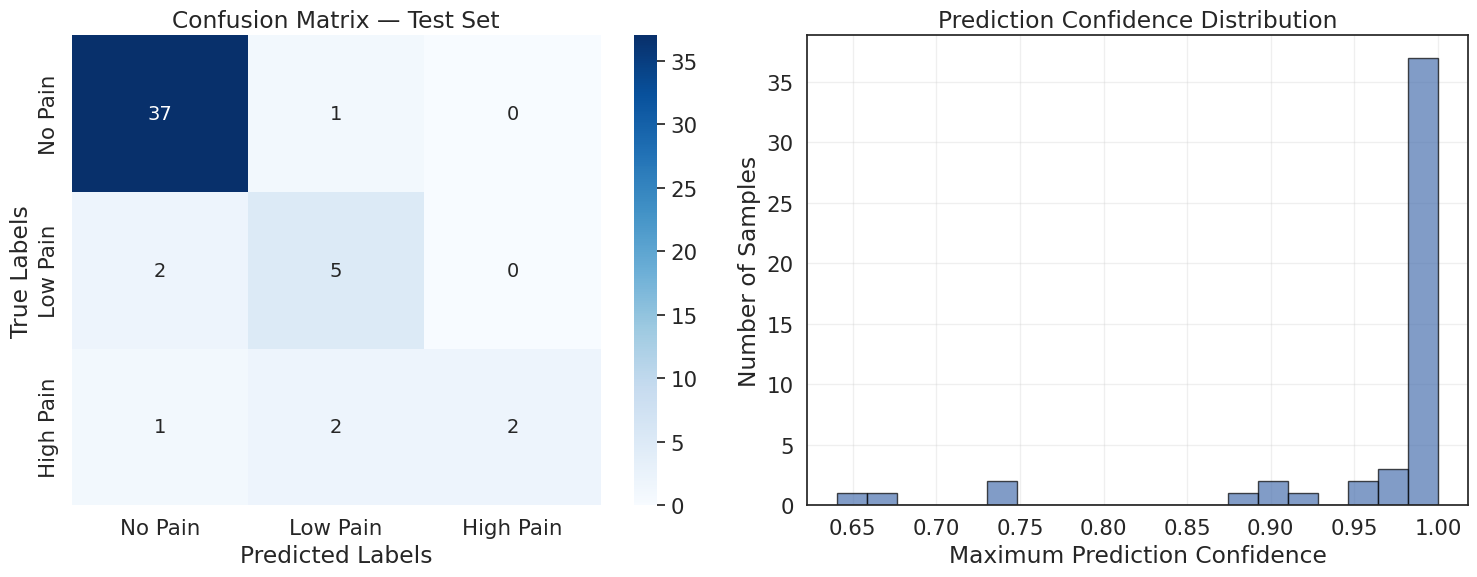


Prediction Confidence Analysis:
-----------------------------------
Mean confidence: 0.9637
Std confidence:  0.0840
Min confidence:  0.6406
Max confidence:  1.0000

Samples with confidence < 0.6: 0 (0.0%)


In [261]:
# --- Test Set Confusion Matrix and Visualizations ---

# Generate confusion matrix for detailed error analysis
cm_test = confusion_matrix(test_targets, test_preds)

# Create the confusion matrix plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Confusion Matrix
labels = np.array([f"{num}" for num in cm_test.flatten()]).reshape(cm_test.shape)
sns.heatmap(cm_test, annot=labels, fmt='', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=ax1)
ax1.set_xlabel('Predicted Labels')
ax1.set_ylabel('True Labels')
ax1.set_title('Confusion Matrix — Test Set')

# Prediction confidence distribution
max_probs = np.max(test_probabilities, axis=1)
ax2.hist(max_probs, bins=20, alpha=0.7, edgecolor='black')
ax2.set_xlabel('Maximum Prediction Confidence')
ax2.set_ylabel('Number of Samples')
ax2.set_title('Prediction Confidence Distribution')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Analyze prediction confidence
print("\nPrediction Confidence Analysis:")
print("-" * 35)
print(f"Mean confidence: {np.mean(max_probs):.4f}")
print(f"Std confidence:  {np.std(max_probs):.4f}")
print(f"Min confidence:  {np.min(max_probs):.4f}")
print(f"Max confidence:  {np.max(max_probs):.4f}")

# Low confidence predictions (potentially uncertain)
low_confidence_threshold = 0.6
low_conf_indices = np.where(max_probs < low_confidence_threshold)[0]
print(f"\nSamples with confidence < {low_confidence_threshold}: {len(low_conf_indices)} ({len(low_conf_indices)/len(test_preds)*100:.1f}%)")

if len(low_conf_indices) > 0:
    print("Low confidence predictions breakdown:")
    for i in range(num_classes):
        low_conf_class = np.sum(test_preds[low_conf_indices] == i)
        print(f"  {class_names[i]}: {low_conf_class} samples")

In [262]:
# --- Advanced Error Analysis ---

# Detailed error analysis
misclassified_indices = np.where(test_preds != test_targets)[0]
print(f"Total misclassified samples: {len(misclassified_indices)} out of {len(test_targets)}")
print(f"Error rate: {len(misclassified_indices)/len(test_targets)*100:.2f}%")

if len(misclassified_indices) > 0:
    print("\nMisclassification Analysis:")
    print("-" * 30)
    
    # Create a detailed breakdown of errors
    error_matrix = np.zeros((num_classes, num_classes), dtype=int)
    for idx in misclassified_indices:
        true_class = test_targets[idx]
        pred_class = test_preds[idx]
        error_matrix[true_class, pred_class] += 1
    
    print("Error Matrix (True → Predicted):")
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j and error_matrix[i, j] > 0:
                print(f"  {class_names[i]} → {class_names[j]}: {error_matrix[i, j]} errors")
    
    # Analyze confidence of misclassified samples
    misclass_confidence = max_probs[misclassified_indices]
    correct_confidence = max_probs[test_preds == test_targets]
    
    print(f"\nConfidence comparison:")
    print(f"  Correct predictions:   {np.mean(correct_confidence):.4f} ± {np.std(correct_confidence):.4f}")
    print(f"  Incorrect predictions: {np.mean(misclass_confidence):.4f} ± {np.std(misclass_confidence):.4f}")

# Final model performance summary
print("\n" + "="*70)
print("                    FINAL MODEL PERFORMANCE SUMMARY")
print("="*70)
print(f"Model Architecture: {rnn_model.rnn_type} (Bidirectional: {rnn_model.bidirectional})")
print(f"Hidden Size: {rnn_model.hidden_size}, Layers: {rnn_model.num_layers}")
print(f"Input Features: {input_shape[-1]}, Sequence Length: {input_shape[0]}")
print(f"Training Parameters: Batch Size: {BATCH_SIZE}, Window: {WINDOW_SIZE}, Stride: {STRIDE}")
print()
print("Test Set Performance:")
print(f"  • Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  • Precision: {test_precision:.4f}")
print(f"  • Recall:    {test_recall:.4f}")
print(f"  • F1 Score:  {test_f1:.4f}")
print()
print(f"Total Parameters: {sum(p.numel() for p in rnn_model.parameters()):,}")
print(f"Trainable Parameters: {sum(p.numel() for p in rnn_model.parameters() if p.requires_grad):,}")
print("="*70)

# Save test results to a summary file (optional)
test_results = {
    'test_accuracy': float(test_accuracy),
    'test_precision': float(test_precision),
    'test_recall': float(test_recall),
    'test_f1': float(test_f1),
    'per_class_f1': test_f1_per_class.tolist(),
    'confusion_matrix': cm_test.tolist(),
    'model_params': {
        'rnn_type': rnn_model.rnn_type,
        'hidden_size': rnn_model.hidden_size,
        'num_layers': rnn_model.num_layers,
        'bidirectional': rnn_model.bidirectional,
        'total_params': sum(p.numel() for p in rnn_model.parameters())
    }
}

import json
with open('test_results.json', 'w') as f:
    json.dump(test_results, f, indent=2)
    
print(f"\nTest results saved to 'test_results.json'")

Total misclassified samples: 6 out of 50
Error rate: 12.00%

Misclassification Analysis:
------------------------------
Error Matrix (True → Predicted):
  No Pain → Low Pain: 1 errors
  Low Pain → No Pain: 2 errors
  High Pain → No Pain: 1 errors
  High Pain → Low Pain: 2 errors

Confidence comparison:
  Correct predictions:   0.9797 ± 0.0554
  Incorrect predictions: 0.8462 ± 0.1435

                    FINAL MODEL PERFORMANCE SUMMARY
Model Architecture: LSTM (Bidirectional: True)
Hidden Size: 80, Layers: 2
Input Features: 38, Sequence Length: 320
Training Parameters: Batch Size: 256, Window: 320, Stride: 80

Test Set Performance:
  • Accuracy:  0.8800 (88.00%)
  • Precision: 0.8905
  • Recall:    0.8800
  • F1 Score:  0.8715

Total Parameters: 231,523
Trainable Parameters: 231,523

Test results saved to 'test_results.json'
